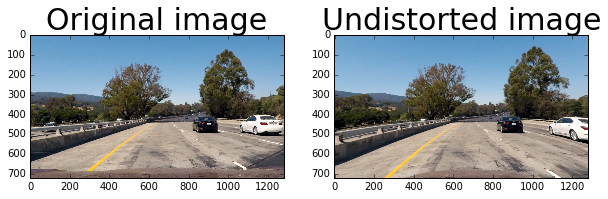

In [17]:
import numpy as np
import cv2
import matplotlib.pyplot as pyplot
import matplotlib.image as mpimg
import glob
import pickle

%matplotlib inline

calib_images = 'camera_cal/*.jpg'
test_image_fname = 'test_images/test1.jpg'

calib_pickle_file = 'cam_cal_dist.p'

# Perspective transform source and destination coordinates. 
warp_arr_src = [[590, 450], [200, 700], [1110, 700], [690, 450]]
warp_arr_dst = [[320, 0], [320, 700], [970, 700], [970, 0]]


def calibrate_camera(calib_image_path, test_image_fname):
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    images = glob.glob(calib_image_path)

    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
    
    img = cv2.imread(test_image_fname)
    img_size = (img.shape[1], img.shape[0])
    
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    
    return ret, mtx, dist, rvecs, tvecs

def save_calib(mtx, dist, output_fname):
    dst_pickle = {}
    dst_pickle["mtx"] = mtx
    dst_pickle["dist"] = dist
    pickle.dump(dst_pickle, open(calib_pickle_file, "wb"))
    
def undistort(img, mtx, dist):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

def warp(img):
    img_size = (img.shape[1], img.shape[0])
    src = np.float32(warp_arr_src)
    dst = np.float32(warp_arr_dst)
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M, Minv

def read_image(fname):
    img = mpimg.imread(fname)
    return img

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    x, y = 0, 0
    if (orient=='x'):
        x = 1
    else:
        y = 1
    print("x= {}, y= {}".format(x,y))
    sobelxy = cv2.Sobel(gray, cv2.CV_64F, x, y, ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobelxy = np.absolute(sobelxy)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
    # is > thresh_min and < thresh_max
 
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return sxbinary 

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    abs_sobelxy = np.sqrt(sobelx*sobelx + sobely*sobely)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    # 5) Create a binary mask where mag thresholds are met
    thresh_min = mag_thresh[0]
    thresh_max = mag_thresh[1]
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1 
    return sxbinary 

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    dir_sobelxy = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    sxbinary = np.zeros_like(dir_sobelxy)
    sxbinary[(dir_sobelxy >= thresh_min) & (dir_sobelxy <= thresh_max)] = 1
    return sxbinary 

def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    s_hls = hls[:, :, 2]
    thresh_hls = np.zeros_like(s_hls)
    thresh_hls[(s_hls > thresh[0]) & (s_hls <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return thresh_hls

def apply_thresholds(image):
    # Choose a Sobel kernel size
    ksize = 15 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(20, 100))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=3, thresh=(30, 200))
    mag_binary = mag_thresh(image, sobel_kernel=13, mag_thresh=(30, 100))

    pi_by_2 = np.pi/2
    dir_binary = dir_threshold(image, sobel_kernel=13, thresh=(0.7, 1.3))

    hls_mask = hls_select(image, (170, 255))
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (hls_mask == 1)] = 1
    sobel_s_x = np.zeros_like(dir_binary)
    sobel_s_x[(gradx == 1) | (hls_mask == 1)] = 1
    return combined, sobel_s_x, gradx, grady, mag_binary, dir_binary, hls_mask

def apply_sx_thresholds(image):
    # Choose a Sobel kernel size
    ksize = 15 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(20, 100))

    hls_mask = hls_select(image, (170, 255))
    sobel_s_x = np.zeros_like(dir_binary)
    sobel_s_x[(gradx == 1) | (hls_mask == 1)] = 1
    return sobel_s_x

# Step 1: Calibrate the camera and save the calibration matrix
ret, mtx, dist, rvecs, tvecs = calibrate_camera(calib_images, test_image_fname)
save_calib(mtx, dist, calib_pickle_file)
image = read_image(test_image_fname)

# Step 2: Undistort the a test image and plot it side by side.
img_d = cv2.undistort(image, mtx, dist, None, mtx)
cv2.imwrite('/tmp/test_undist.jpg', img_d)

dst_pickle = {}
dst_pickle["mtx"] = mtx
dst_pickle["dist"] = dist
pickle.dump(dst_pickle, open("cam_cal_dist.p", "wb") )

f, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(10,20))

ax1.imshow(image)
ax1.set_title("Original image", fontsize=30)

ax2.imshow(img_d)
ax2.set_title("Undistorted image", fontsize=30)

x= 1, y= 0
x= 0, y= 1


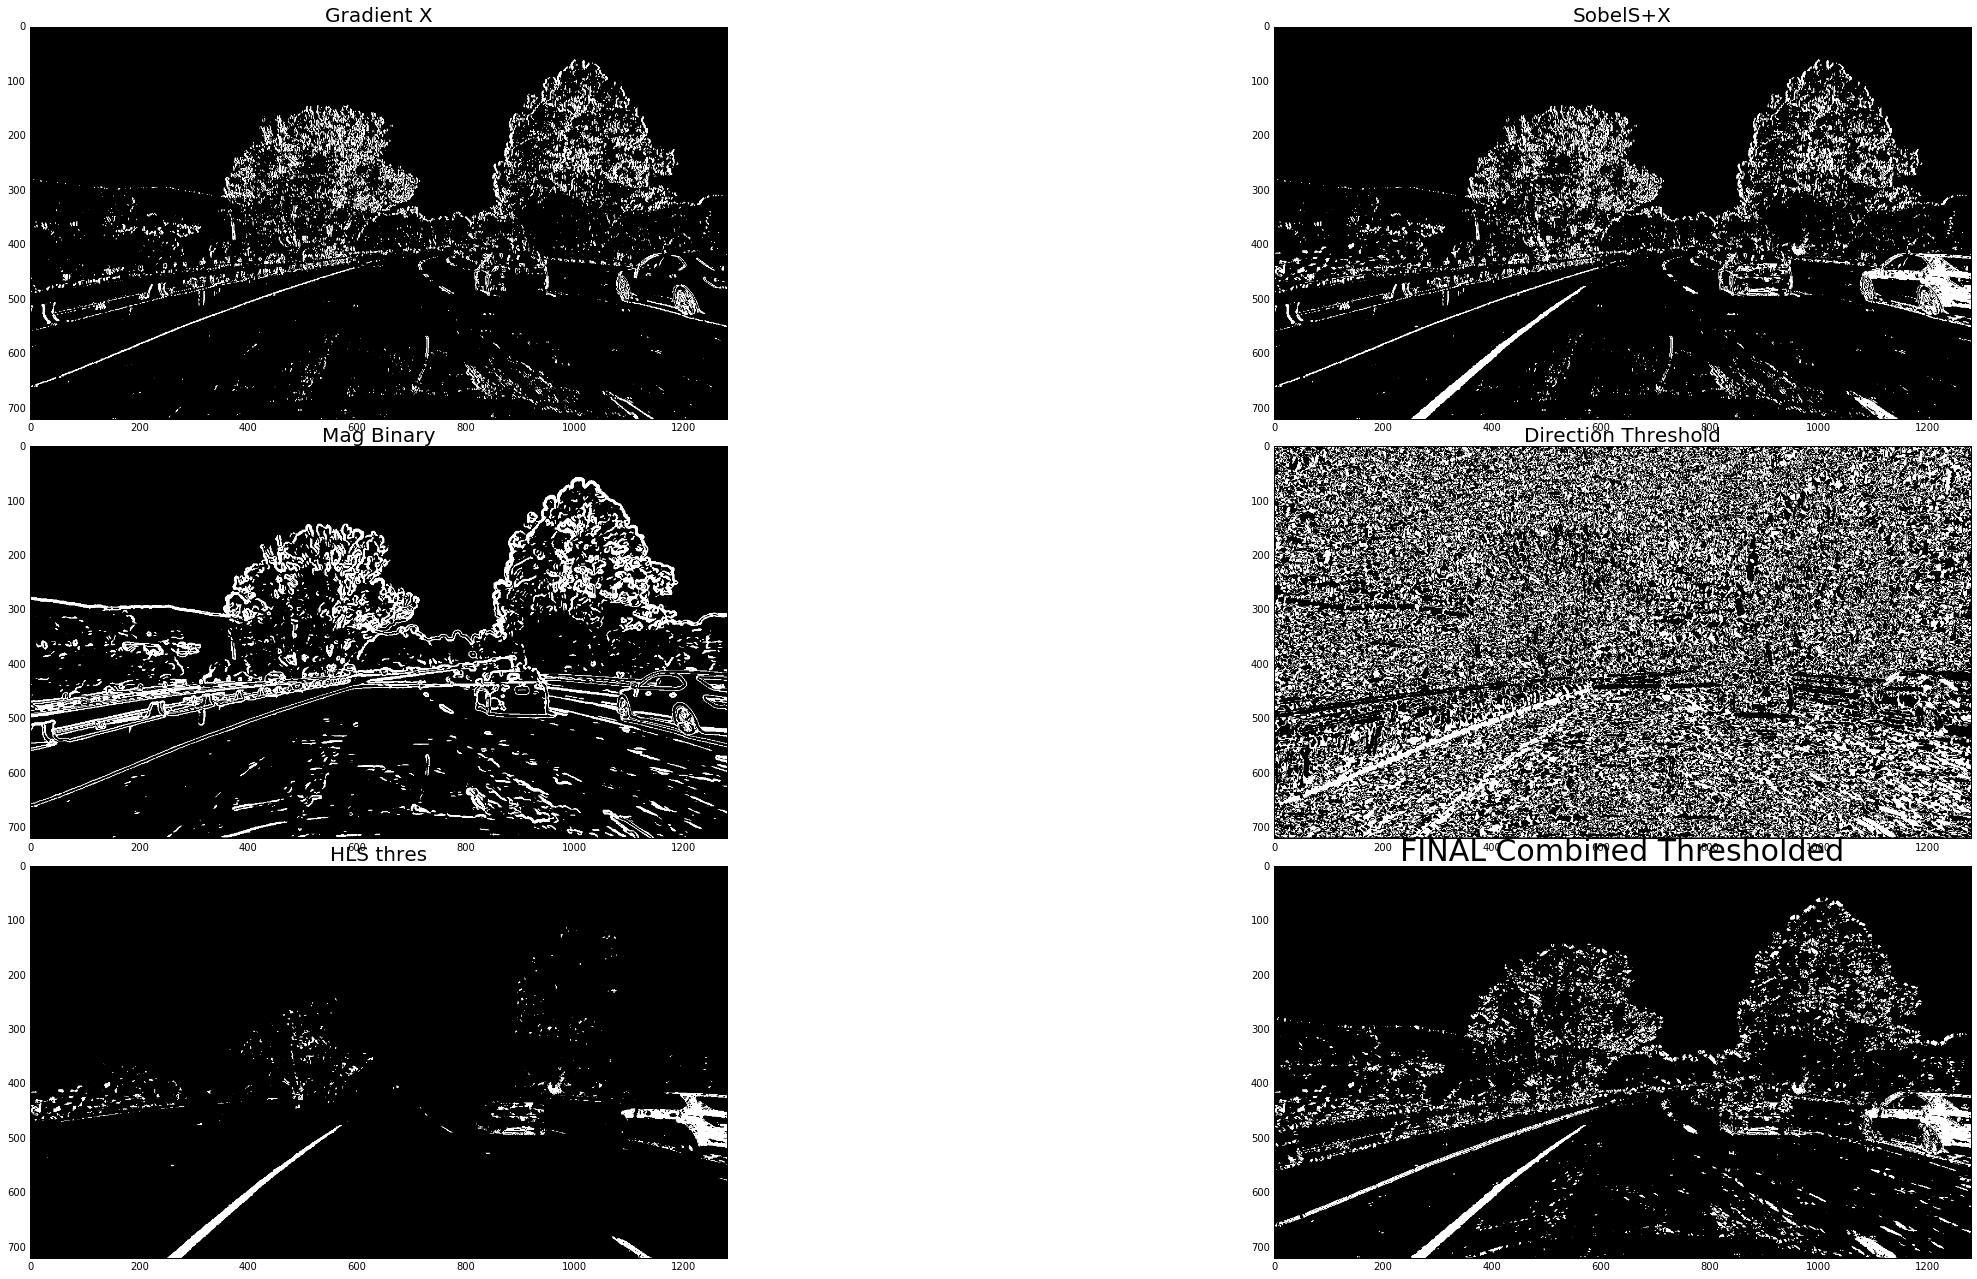

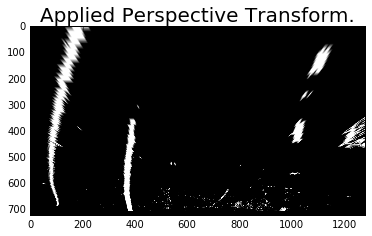

In [18]:

# Step 3: Use color transforms, gradients, etc., to create a thresholded binary image.
img_thres, sobel_sx, gradx, grady, mag_binary, dir_binary, hls_mask = apply_thresholds(img_d)

# Plot the result
f, all_plots = pyplot.subplots(3, 2, figsize=(34, 19))
f.tight_layout()
all_plots[0,0].imshow(gradx, cmap='gray')
all_plots[0,0].set_title('Gradient X', fontsize=20)

all_plots[0,1].imshow(sobel_sx, cmap='gray')
all_plots[0,1].set_title('SobelS+X', fontsize=20)

all_plots[1,0].imshow(mag_binary, cmap='gray')
all_plots[1,0].set_title('Mag Binary', fontsize=20)

all_plots[1,1].imshow(dir_binary, cmap='gray')
all_plots[1,1].set_title('Direction Threshold', fontsize=20)

all_plots[2,0].imshow(hls_mask, cmap='gray')
all_plots[2,0].set_title('HLS thres', fontsize=20)

all_plots[2,1].imshow(img_thres, cmap='gray')
all_plots[2,1].set_title('FINAL Combined Thresholded', fontsize=30)

pyplot.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
pyplot.show()



# Step 4: Apply a perspective transform to rectify binary image ("birds-eye view").
img_w, M, Minv = warp(sobel_sx)
pyplot.imshow(img_w, cmap='gray')
pyplot.title("Applied Perspective Transform.", fontsize=20)


In [19]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
def compute_fresh_lines(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    out_img = (np.dstack((binary_warped, binary_warped, binary_warped))*255).astype(np.uint8)
    
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # nwindows = 9
    nwindows = 9
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()

    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    leftx_current = leftx_base
    rightx_current = rightx_base

    # Set the width of the windows +/- margin
    margin = 100
    
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
    
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0,255,0), 2)
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 2) 
        good_left_inds =  ((nonzeroy > win_y_low) & (nonzeroy < win_y_high) & (nonzerox > win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds =  ((nonzeroy > win_y_low) & (nonzeroy < win_y_high) & (nonzerox > win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
    
        if (len(good_left_inds) > minpix):
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if (len(good_right_inds) > minpix):
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]

    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    right_line = Line()
    right_line.detected = True
    right_line.allx = rightx
    right_line.ally = righty
    right_line.current_fit = right_fit
    right_line.best_fit = right_fit
    
    left_line = Line()
    left_line.detected = True
    left_line.allx = leftx
    left_line.ally = lefty
    left_line.current_fit = left_fit
    left_line.best_fit = left_fit
    return left_line, right_line


def compute_incremental_lines(binary_warped, left_line, right_line):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    
    left_fit = left_line.current_fit
    right_fit = right_line.current_fit
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    left_line.current_fit = left_fit
    right_line.current_fit = right_fit
    return left_line, right_line

def calculate_curvature(left_line, right_line):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    return np.average(left_curverad, right_curverad)

def draw_lines_onto_image(orig_image, warped_image, Minv, left_line, right_line):
    ploty = np.linspace(0, warped_image.shape[0]-1, warped_image.shape[0])
    left_fit = left_line.current_fit
    right_fit = right_line.current_fit
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
   
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (warped_image.shape[1], warped_image.shape[0])) 

    # Combine the result with the original image
    result = cv2.addWeighted(orig_image, 1, newwarp, 0.3, 0)
    return result

def print_curvature(image, curvature_kms):
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(image,'OpenCV',(10,10), font, 4,(255,255,255),2,cv2.LINE_AA)
    return image
    
def process_image(input_image):
    img_d = cv2.undistort(input_image, mtx, dist, None, mtx)
    img_thres = apply_sx_thresholds(img_d)
    img_w, M, Minv = warp(img_thres)
    left_line, right_line = compute_fresh_lines(img_w)
    output_image = draw_lines_onto_image(input_image, img_w, Minv, left_line, right_line)
    curvature_meters = calculate_curvature(left_line, right_line)
    print_curvature(output_image, curvature_meters/1000.0)
    return output_image
    
project_output = 'project_video_out.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(project_output, audio=False)

x= 1, y= 0


NameError: name 'ploty' is not defined

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))